# Import

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset

#===========================

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualisation of the datasets 

In [2]:
# print the organisation of the datasets folder until the files using os.walk
import os

for root, dirs, files in os.walk('datasets'):
    level = root.replace('datasets', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)

        
#===========================

In [3]:
train_data = np.load(f'../datasets/UTS/WSD/1/train.npy')
print(train_data.shape)
print(train_data[0])
print(type(train_data))

(18235,)
50.0833320618
<class 'numpy.ndarray'>


In [4]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# Select 5 random folders
folders = os.listdir('../datasets/UTS/WSD')
folders = random.sample(folders, 5)
folders = [107]
# Plot the train.npy and test.npy files in each selected folder
for folder in folders:
    train_data = np.load(f'../datasets/UTS/WSD/{folder}/train.npy')
    print
    test_data = np.load(f'../datasets/UTS/WSD/{folder}/test.npy')
    
    train_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/train_timestamp.npy')
    test_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/test_timestamp.npy')
    
    # Plot the train and test data in one figure using different colors
    plt.figure(figsize=(20, 5))
    plt.plot(train_timestamp, train_data, label='Train')
    plt.plot(test_timestamp, test_data, label='Test')
    
    # Plot anomalies as points in red
    train_label = np.load(f'../datasets/UTS/WSD/{folder}/train_label.npy')
    test_label = np.load(f'../datasets/UTS/WSD/{folder}/test_label.npy')
    
    for i, label in enumerate(train_label):
        if label:
            plt.scatter(train_timestamp[i], train_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
    for i, label in enumerate(test_label):
        if label:
            plt.scatter(test_timestamp[i], test_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
            
    plt.title(f"Data from folder: {folder}")
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    



In [5]:
    
#===========================
# compute the mean and std of the train data in the folder datasets/UTS/WSD/1
train_data = np.load('../datasets/UTS/WSD/1/train.npy')
mean = np.mean(train_data)
std = np.std(train_data)
print(mean, std)

#===========================
# Is train_data a 1D array or a 2D array?
print(train_data.ndim)

# In the variable data save = (train_data as a Tensor, train timestamp as a Tensor)
data = (torch.tensor(train_data), torch.tensor(train_timestamp))
print(data[0].shape, data[1].shape)
print(data)

36.78820118134014 11.438011591627744
1
torch.Size([18235]) torch.Size([18213])
(tensor([50.0833, 48.6667, 46.0833,  ..., 22.5000, 23.3000, 23.9000],
       dtype=torch.float64), tensor([1.5045e+09, 1.5045e+09, 1.5045e+09,  ..., 1.5056e+09, 1.5056e+09,
        1.5056e+09], dtype=torch.float64))


In [6]:
from torch.utils.data import DataLoader
dataloader = DataLoader( data , batch_size=32, shuffle=False, drop_last=True)

print(len(dataloader))
print(type(dataloader))
print(dataloader.batch_size)

for step, batch in enumerate(dataloader):
    print(step, batch[0].shape)

0
<class 'torch.utils.data.dataloader.DataLoader'>
32


# Model debugging

In [7]:
import ddpm_Time_Series_copy
#!python ddpm_Time_Series_point_wize.py --data_path ../datasets/UTS/WSD/1 --output_dir output --num_epochs 1 --train_batch_size 512 --eval_batch_size 512 

# Visualisation of adding noise

In [2]:

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset
from ddpm_Time_Series_copy import TCN 
from ddpm_Time_Series_copy import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding



In [9]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output",
  "train_batch_size": 28,
  "eval_batch_size": 28,
  "num_epochs": 1,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1001,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)



In [10]:

input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        print("Showing input and noisy data")
        
        break
    
    progress_bar.close()
    
#Why it doesn't plot anything ?



/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


Epoch 0:   0%|          | 0/293 [00:00<?, ?it/s]

0
tensor([[-0.0782, -0.0980, -0.0109,  ..., -0.9671, -1.0067, -0.9433],
        [-0.0980, -0.0109,  0.0108,  ..., -1.0067, -0.9433, -0.9374],
        [-0.0109,  0.0108,  0.0900,  ..., -0.9433, -0.9374, -0.9770],
        ...,
        [ 0.1336,  0.4087,  0.0029,  ..., -0.6702, -0.5811, -0.6543],
        [ 0.4087,  0.0029,  0.1375,  ..., -0.5811, -0.6543, -0.5395],
        [ 0.0029,  0.1375,  0.0564,  ..., -0.6543, -0.5395, -0.5771]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0.

Epoch 0:   0%|          | 0/293 [00:00<?, ?it/s]

Showing input and noisy data


Explanation:
Constructor: Initializes the parameters similar to the original NoiseScheduler class.
generate_simplex_noise_like Method: Generates a tensor of Simplex noise with the same shape as the input tensor.
step Method: Uses Simplex noise instead of Gaussian noise for the variance term.
add_noise Method: Unchanged, it adds noise to the input data.
This new class SimplexNoiseScheduler will generate and use Simplex noise for the noise addition and sampling steps. The noise generation is done using the noise library's pnoise3 function, which generates 3D Perlin noise (Simplex noise). Adjust the noise generation as needed for your specific application and noise characteristics.

In [15]:
import torch
import torch.nn.functional as F
from opensimplex import OpenSimplex

class SimplexNoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)
        
        self.simplex = OpenSimplex(seed=42)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = self.generate_simplex_noise_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def generate_simplex_noise_like(self, tensor):
        shape = tensor.shape
        simplex_noise = torch.zeros_like(tensor)
        for i in range(shape[0]):
            for j in range(shape[1]):
                simplex_noise[i, j] = self.simplex.noise2(i, j)
        return simplex_noise

    def __len__(self):
        return self.num_timesteps


In [16]:
sequence_length = 18200
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        break

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


Epoch 0:   0%|          | 0/293 [00:00<?, ?it/s]

0
tensor([[-0.0782, -0.0980, -0.0109,  ..., -0.9671, -1.0067, -0.9433],
        [-0.0980, -0.0109,  0.0108,  ..., -1.0067, -0.9433, -0.9374],
        [-0.0109,  0.0108,  0.0900,  ..., -0.9433, -0.9374, -0.9770],
        ...,
        [ 0.1336,  0.4087,  0.0029,  ..., -0.6702, -0.5811, -0.6543],
        [ 0.4087,  0.0029,  0.1375,  ..., -0.5811, -0.6543, -0.5395],
        [ 0.0029,  0.1375,  0.0564,  ..., -0.6543, -0.5395, -0.5771]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0.

timesteps tensor([368, 524, 151, 512, 682, 983, 744, 277, 999, 818, 797, 520, 616, 604,
        306, 324, 674,  16, 281, 150, 284, 177,  10, 666, 284, 883,   1, 613])
Batch shape: torch.Size([28, 10000])
Noise shape: torch.Size([28, 10000])
Noisy shape: torch.Size([28, 10000])


  0%|          | 0/293 [00:03<?, ?it/s]


# Reconstruction steps visualisation :

In [1]:

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from ddpm_Time_Series_copy import TCN 
from ddpm_Time_Series_copy import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output",
  "train_batch_size": 16,
  "eval_batch_size": 16,
  "num_epochs": 50,
  
  "learning_rate": 0.0001,
  "num_timesteps": 500,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)

## Ajout de buits de manière random et départ d'un step totalement random: 

The Evaluation and visualization part of the code performs the following tasks:


1. Model Evaluation:
   - It switches the model to evaluation mode (`model.eval()`).
   - This part runs every 5 epochs or at the end of training.

2. Sample Generation:
   - It creates a batch of random noise samples (`torch.randn(eval_batch_size, sequence_length)`).
   - It then uses the trained model to gradually denoise these samples.

3. Denoising Process:
   - It iterates through the timesteps in reverse order.
   - For each timestep, it:
     a. Creates a tensor of the current timestep.
     b. Uses the model to predict the residual noise.
     c. Applies the noise scheduler to update the sample.

4. Visualization:
   - It creates a 2x2 grid of subplots.
   - For up to 4 generated samples:
     a. It plots each sample on a subplot.
     b. Sets titles, labels, and adjusts the layout.
   - Finally, it displays the plot.

This process allows you to visually inspect the quality of the generated samples throughout the training process, helping you assess how well the model is learning to generate time series data.

Would you like me to explain any specific part of this process in more detail?

In [40]:
# 2. Custom Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, pred, target):
        mse_loss = F.mse_loss(pred, target)
        ssim_loss = 1 - ssim(pred.unsqueeze(1), target.unsqueeze(1), data_range=1, size_average=True)
        spectral_loss = torch.mean(torch.abs(torch.fft.rfft(pred) - torch.fft.rfft(target)))
        return self.alpha * mse_loss + self.beta * ssim_loss + self.gamma * spectral_loss

In [33]:
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print("timesteps", timesteps)
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        #print(f"Batch shape: {batch.shape}")
        #print(f"Noise shape: {noise.shape}")
        #print(f"Noisy shape: {noisy.shape}")
        
        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        
        """order proposed by claude --- to verify """
        #loss = nn.MSELoss()(noise_pred, noise)
        loss = CombinedLoss()(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
    print(f"epoch number {epoch} done")
    print("number of epochs in the configuration", config.num_epochs)
    
    # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size
        sample = torch.randn(eval_batch_size, sequence_length)
        timesteps = list(range(noise_scheduler.num_timesteps))[::-1]

        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="Sampling")):
                time_tensor = torch.full((eval_batch_size,), t, device=sample.device, dtype=torch.long)
                residual = model(sample, time_tensor)
                sample = noise_scheduler.step(residual, time_tensor[0], sample)
    
        # Visualize the generated samples
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Changed to 2 rows, 5 columns
        for i in range(eval_batch_size):
            ax = axs[i // 5, i % 5]  # Adjust subplot selection
            ax.plot(sample[i].cpu().numpy())
            ax.set_title(f"Sample {i+1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick labels

        plt.tight_layout()
        plt.show()

        
    progress_bar.close()


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


  0%|          | 0/1 [00:00<?, ?it/s]?, ?it/s]

timesteps tensor([195, 344, 150, 377, 196, 470, 297,  63,  73,  76,  49, 164, 295, 239,
         99, 414])


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [23]:
#!pip install pytorch-msssim

In [28]:
import torch

device = None
# Check if GPU is available
device = torch.device( "cpu")

# Your code here


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import RandomRotation, RandomHorizontalFlip
from pytorch_msssim import ssim

# 1. Improved TCN Model
class ImprovedTemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(ImprovedTemporalBlock, self).__init__()
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                                    stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                                    stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

        # Add Batch Normalization
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.bn2 = nn.BatchNorm1d(n_outputs)

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.bn1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class ImprovedTCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(ImprovedTCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [ImprovedTemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x, t):
        # x shape: [batch_size, sequence_length, features]
        # t shape: [batch_size]
        
        # Expand t to match x's sequence length
        t = t.unsqueeze(1).unsqueeze(2).expand(-1, x.size(1), -1)
        
        # Concatenate x and t along the feature dimension
        x = torch.cat([x, t], dim=-1)
        
        # Permute dimensions to [batch_size, features, sequence_length]
        x = x.permute(0, 2, 1)
        
        y1 = self.network(x)
        return self.linear(y1.transpose(1, 2)).squeeze(-1)


# 2. Custom Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, pred, target):
        mse_loss = F.mse_loss(pred, target)
        ssim_loss = 1 - ssim(pred.unsqueeze(1), target.unsqueeze(1), data_range=1, size_average=True)
        spectral_loss = torch.mean(torch.abs(torch.fft.rfft(pred) - torch.fft.rfft(target)))
        return self.alpha * mse_loss + self.beta * ssim_loss + self.gamma * spectral_loss

# 3. Data Augmentation
class TimeSeriesAugmentation:
    def __init__(self, rotation_degrees=5):
        self.rotation = RandomRotation(degrees=rotation_degrees)
        self.flip = RandomHorizontalFlip(p=0.5)

    def __call__(self, x):
        x = self.rotation(x.unsqueeze(0)).squeeze(0)
        x = self.flip(x)
        return x

# 4. Improved Noise Scheduler
class ImprovedNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end, beta_schedule="linear"):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_schedule = beta_schedule
        
        if beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        elif beta_schedule == "cosine":
            self.betas = self._cosine_beta_schedule(num_timesteps)
        
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def _cosine_beta_schedule(self, num_timesteps):
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps)
        alphas_cumprod = torch.cos(((x / num_timesteps) + 0.008) / 1.008 * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        return (
            self.sqrt_alphas_cumprod[t].unsqueeze(-1).unsqueeze(-1) * x
            + self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(-1).unsqueeze(-1) * noise
        )

    def step(self, model_output, timestep, sample):
        t = timestep
        beta_t = self.betas[t]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t]
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t]

        model_mean = (sample - beta_t * model_output / sqrt_one_minus_alphas_cumprod_t) / sqrt_alphas_cumprod_t

        if t == 0:
            return model_mean
        else:
            posterior_variance_t = self.betas[t] * (1. - self.alphas_cumprod[t-1]) / (1. - self.alphas_cumprod[t])
            noise = torch.randn_like(sample)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

# 5. Training Loop with all improvements
def train_improved_model(model, dataloader, num_epochs, device, learning_rate):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added L2 regularization
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    loss_fn = CombinedLoss()
    noise_scheduler = ImprovedNoiseScheduler(num_timesteps=1000, beta_start=1e-4, beta_end=0.02, beta_schedule="cosine")
    augmentation = TimeSeriesAugmentation()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for step, (batch, timestamps, labels) in enumerate(dataloader):
            batch = batch.to(device)
            batch = augmentation(batch)  # Apply data augmentation
            
            optimizer.zero_grad()
            
            # Add noise
            noise = torch.randn_like(batch)
            print(noise.shape)
            
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.shape[0],)).long().to(device)
            noisy_batch = noise_scheduler.add_noise(batch, timesteps)
            
            print(noisy_batch.shape[2] +1)
            # Predict noise
            pred_noise = model(noisy_batch, timesteps)
            
            # Calculate loss
            loss = loss_fn(pred_noise, noise)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        scheduler.step(avg_loss)
        
        # Evaluation code here (similar to your existing code)
        if (epoch % 50 == 0 or epoch == num_epochs - 1) and epoch != 0:
            model.eval()
            # Your existing evaluation code goes here

# 6. Usage
#input_size = x.shape[2] + 1  # number of features + 1 for time
input_size = 5001
model = ImprovedTCN(
    input_size=input_size,
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
).to(device)

# Assuming you have your dataloader set up
train_improved_model(model, dataloader, num_epochs=1000, device=device, learning_rate=1e-4)

torch.Size([16, 5000])
5001


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/tmp/ipykernel_1655556/3944404807.py:109: UserWarning: Using a target size (torch.Size([16, 5000])) that is different to the input size (torch.Size([16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(pred, target)


RuntimeError: The size of tensor a (16) must match the size of tensor b (5000) at non-singleton dimension 1

## Ajout de buit incrémentalement:

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  33,  66,  99, 133, 166, 199, 232, 266, 299, 332, 365, 399, 432,
        465, 499])


Sampling: 100%|██████████| 500/500 [06:16<00:00,  1.33it/s]


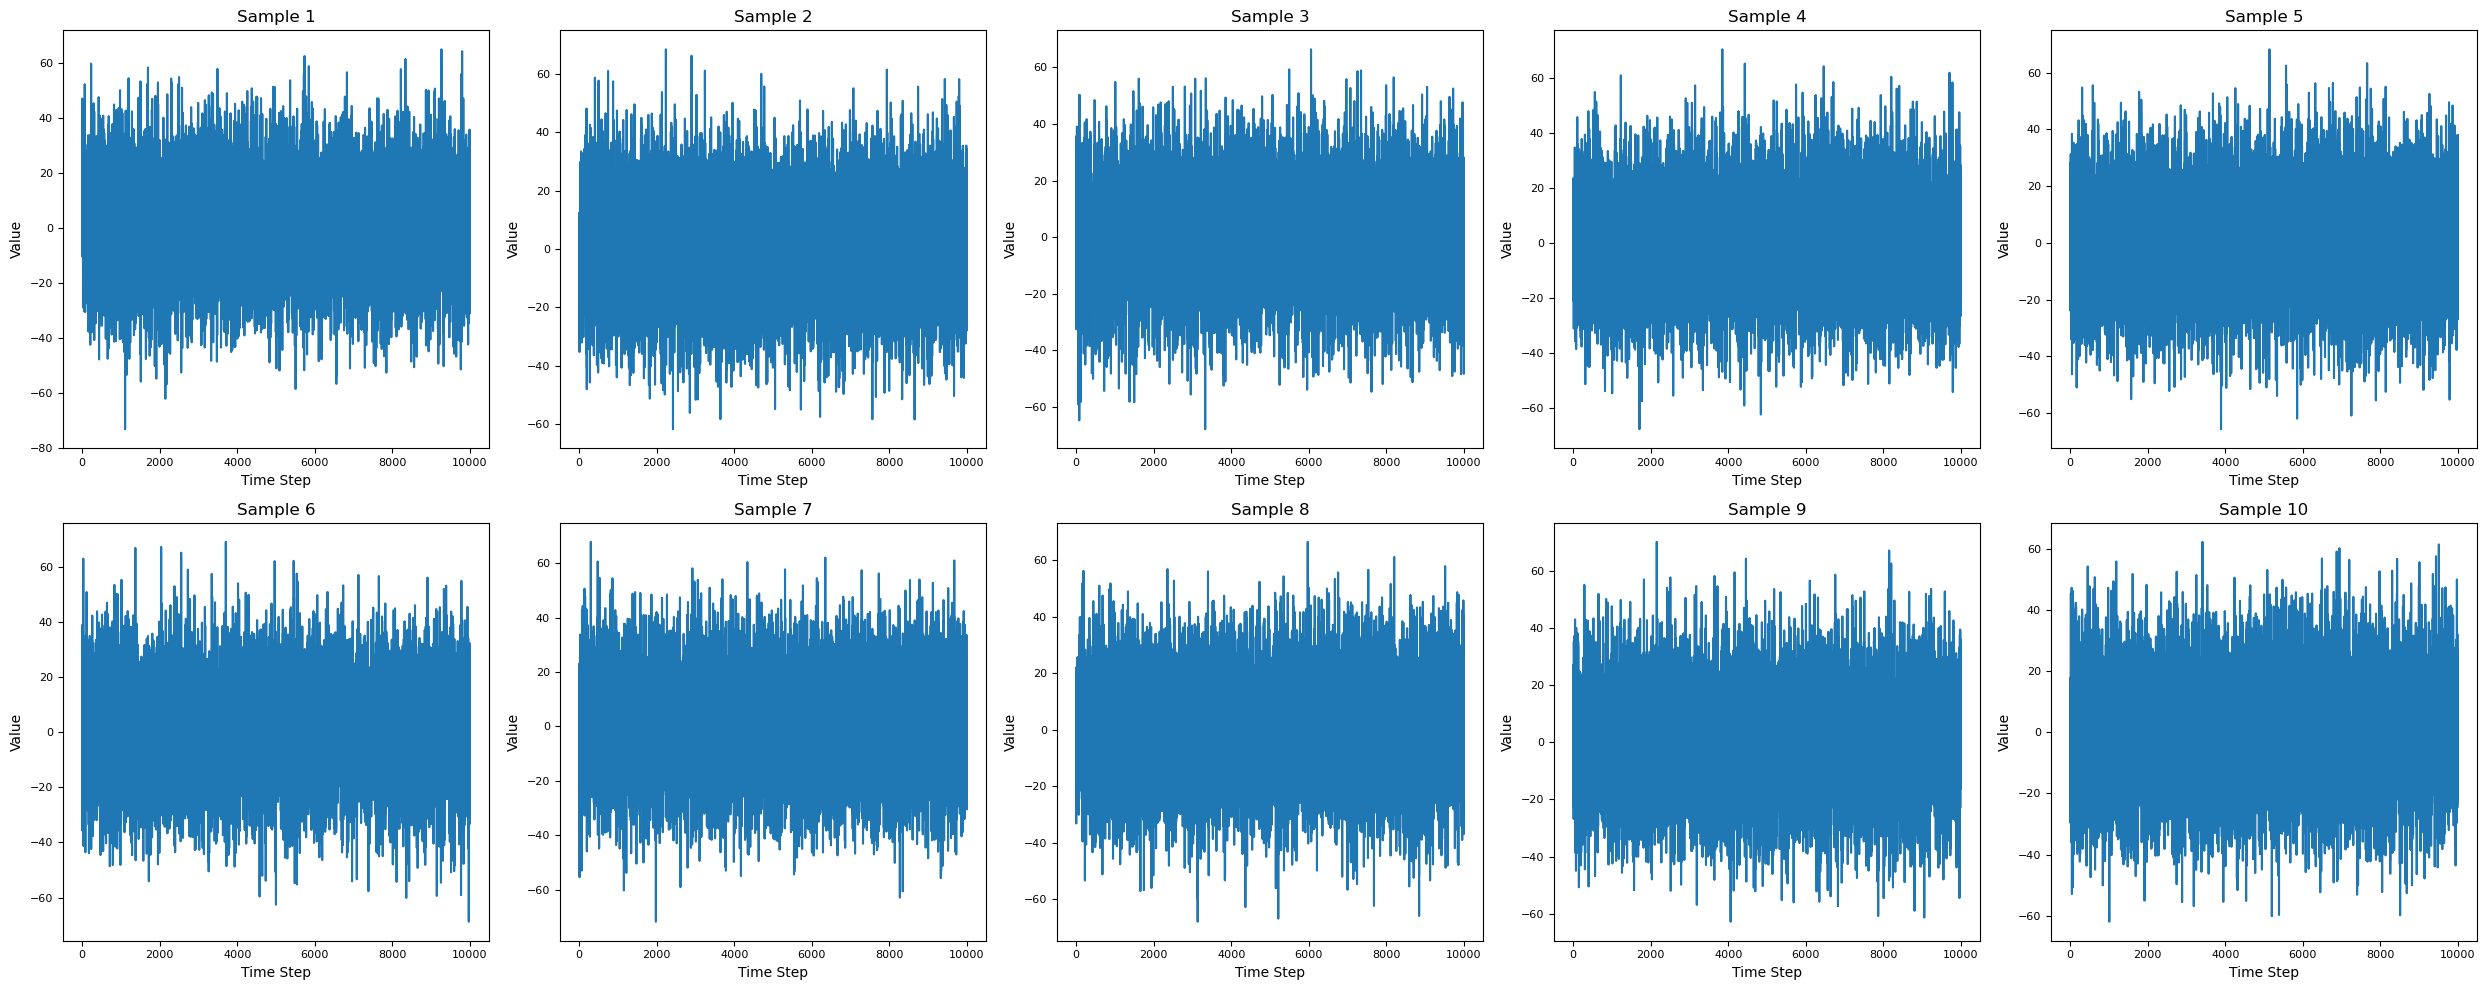

Epoch 49: 100%|██████████| 1/1 [06:19<00:00, 379.55s/it, loss=1, step=49]


In [43]:
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
         # Generate incremental and ordered timesteps for each batch
        timesteps = torch.linspace(
            0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]
        ).long()
        
        print('timesteps', timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size
        sample = torch.randn(eval_batch_size, sequence_length)
        timesteps = list(range(noise_scheduler.num_timesteps))[::-1]

        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="Sampling")):
                time_tensor = torch.full((eval_batch_size,), t, device=sample.device, dtype=torch.long)
                residual = model(sample, time_tensor)
                sample = noise_scheduler.step(residual, time_tensor[0], sample)
    
        # Visualize the generated samples
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Changed to 2 rows, 5 columns
        for i in range(eval_batch_size):
            ax = axs[i // 5, i % 5]  # Adjust subplot selection
            ax.plot(sample[i].cpu().numpy())
            ax.set_title(f"Sample {i+1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick labels

        plt.tight_layout()
        plt.show()

        
    progress_bar.close()


Batch shape: torch.Size([16, 5000])
Noise shape: torch.Size([16, 5000])
Noisy shape: torch.Size([16, 5000])

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.02s/it] 2.02s/it, loss=2.66e+5, step=49]


eval timesteps tensor([442, 245, 100,  59, 467, 307, 312, 100, 450, 267, 365, 449,   3, 371,
        491, 417])


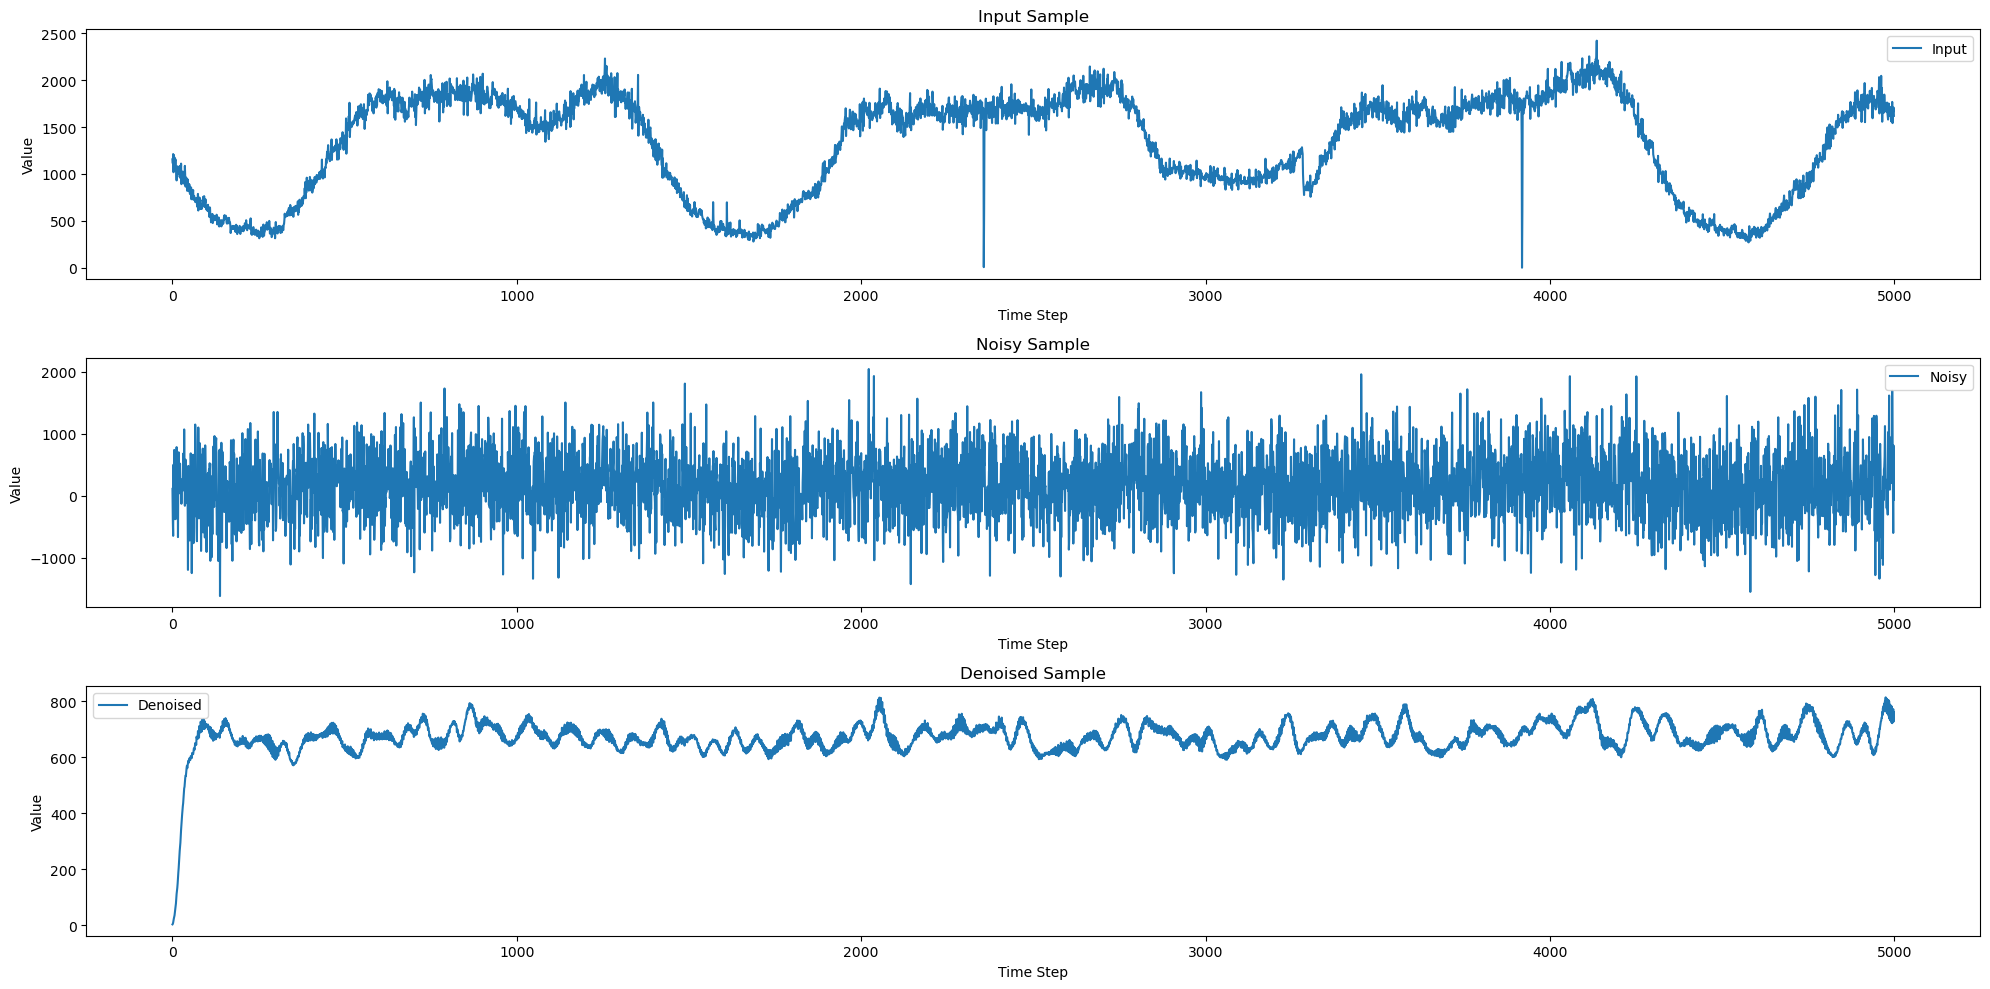

Epoch 49: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, loss=2.66e+5, step=49]


In [33]:
sequence_length = 5000
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)


# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        #noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        #timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
         # Generate incremental and ordered timesteps for each batch
        #timesteps = torch.linspace(0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]).long()
        std_data = torch.std(batch)

        # I want the noise level increasing with epoch
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) * std_data * noise_level
                
        #noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        #print("timesteps", timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(batch)
                noise_level = 1
                noise = torch.randn_like(batch) * std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                denoised_sample = model(noisy_sample, timesteps)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()


  0%|          | 0/1 [00:00<?, ?it/s]

eval timesteps tensor([269, 477, 188, 171, 299,  94, 171, 206,  95, 246, 344, 195,  33, 431,
        498, 289])
std_data tensor(527.8704)


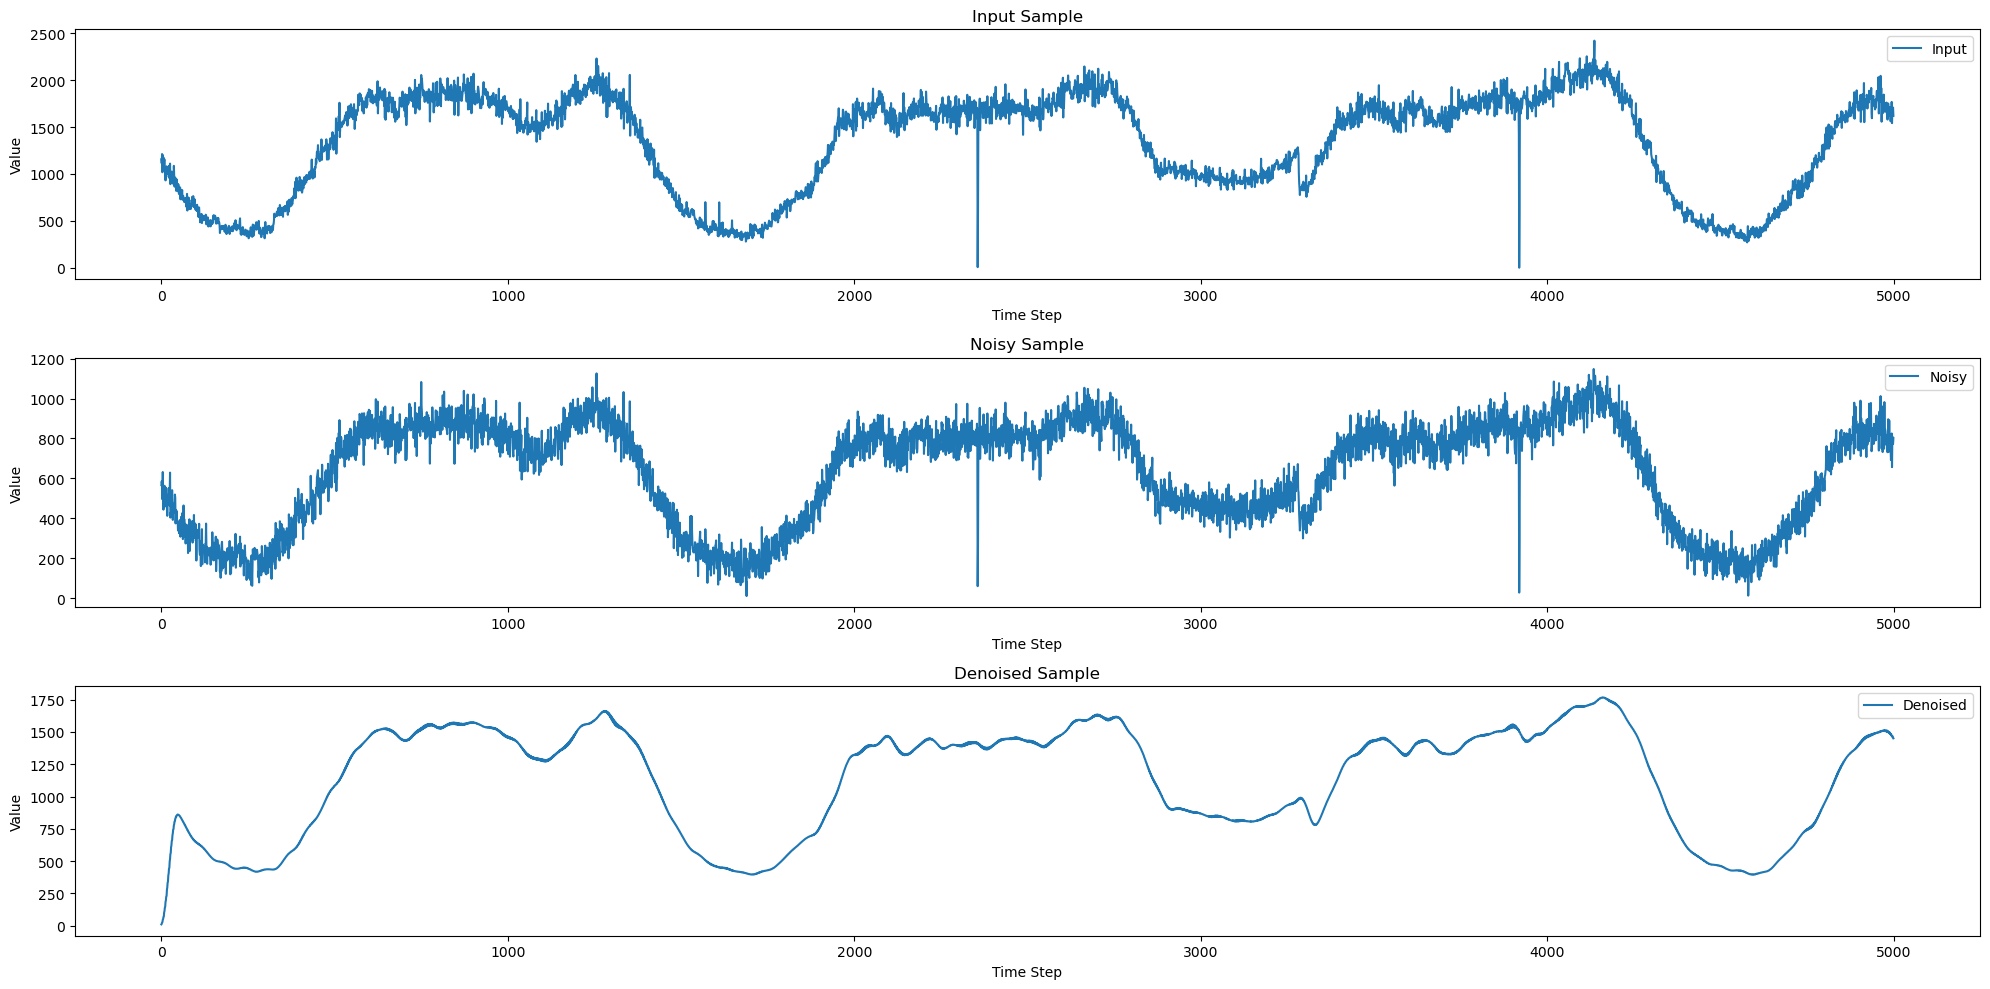

Outliers: [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [False False False ... False False False]]
labels tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


  0%|          | 0/1 [00:00<?, ?it/s]


In [62]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
        
        std_data = torch.std(sample)
        print("std_data", std_data)
        noise_level = 0.1
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        denoised_sample = model(sample, timesteps)
        
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = 600
        
        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        #outlier_indices = np.where(outliers[0] == 1)[0]
        #ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")
        
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
    break

Test results :  with shuffle =  FALSE on 5000 data batch size 16 and normalize = TRUE 

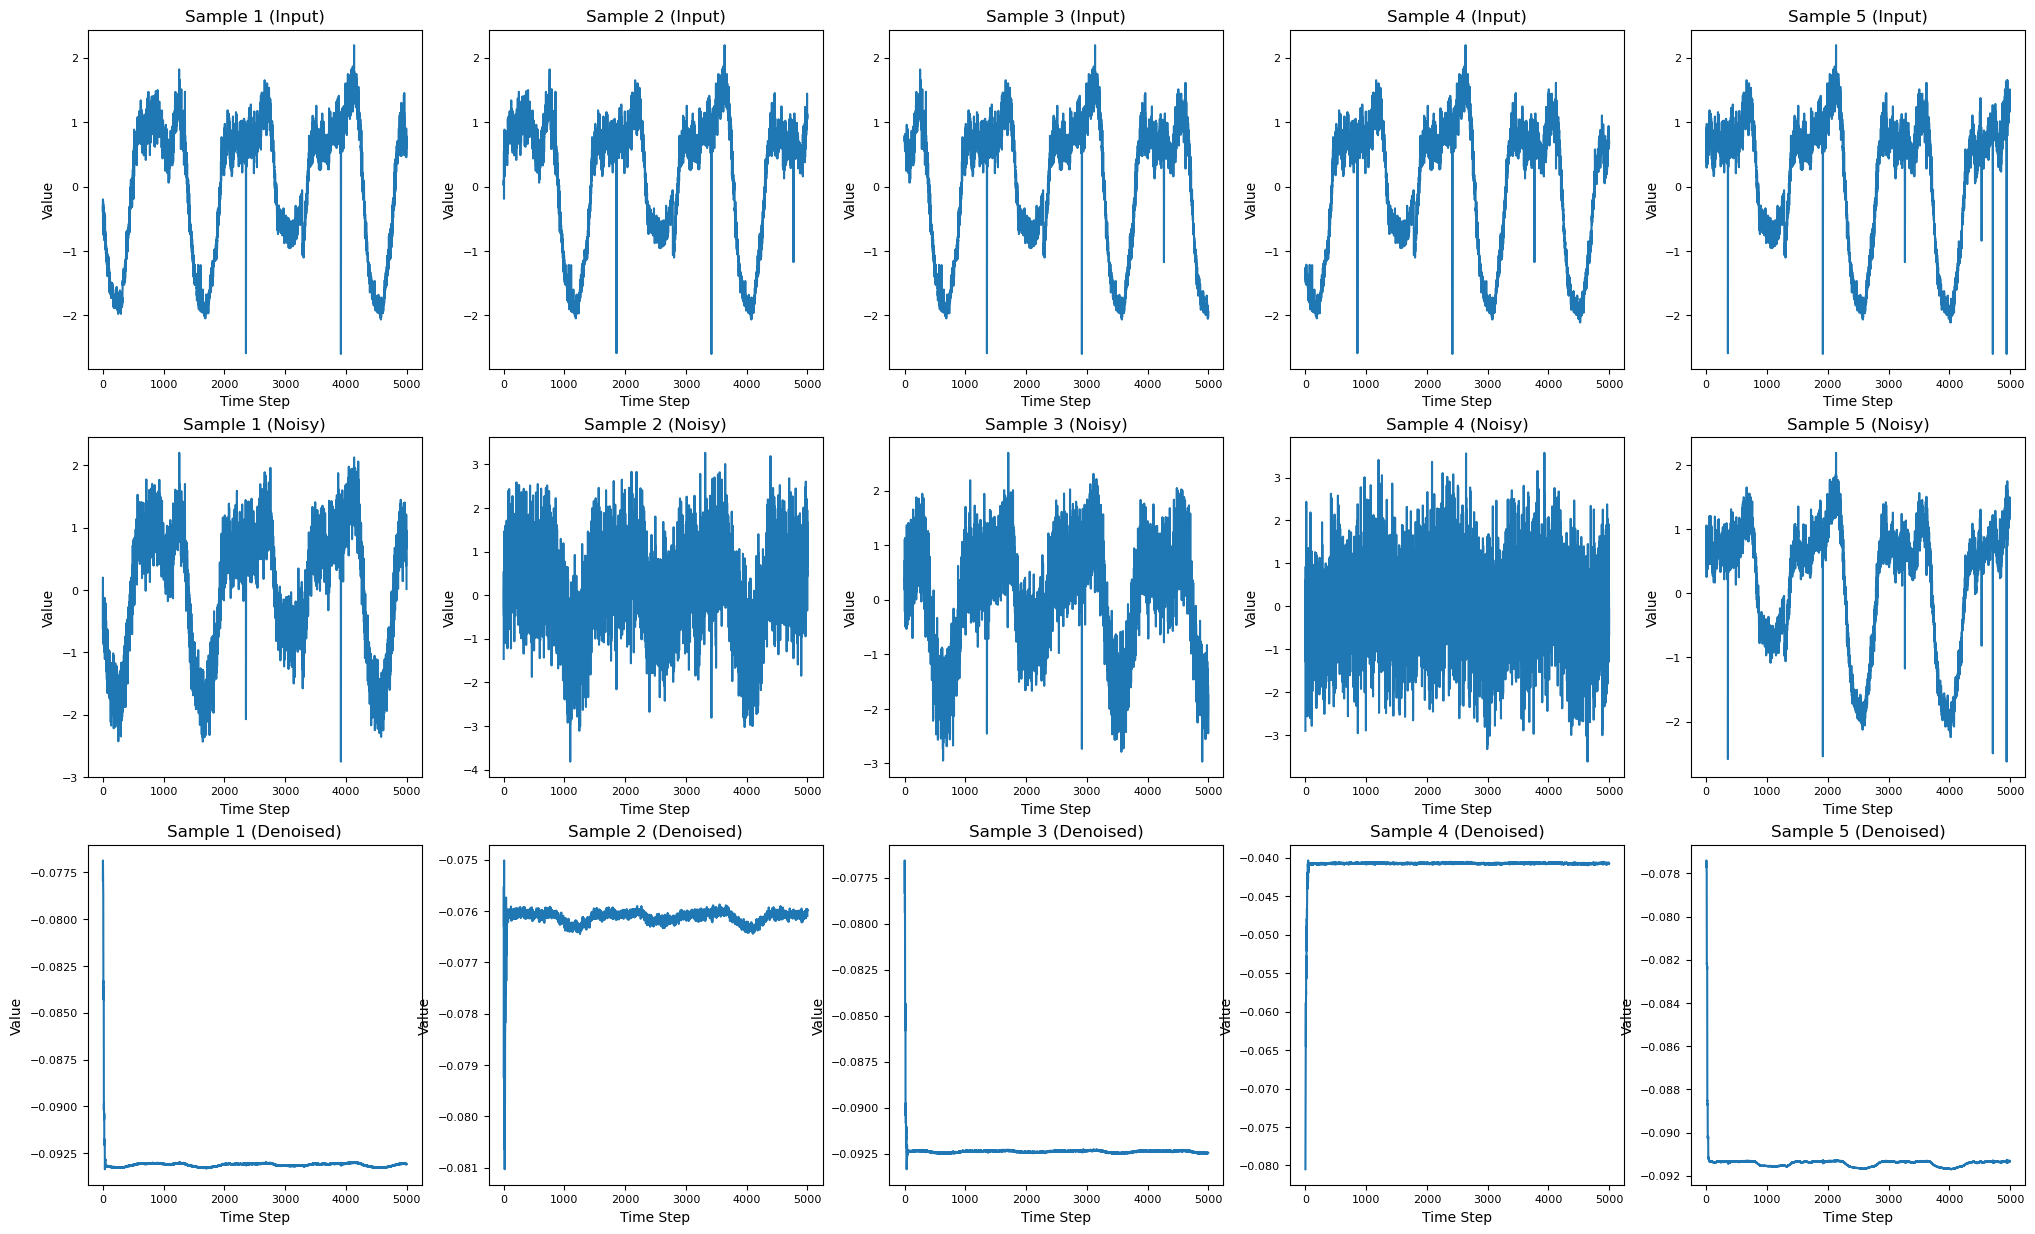

st results :  with shuffle =  TRUE on 5000 data batch size 16 and normalize = TRUE 


In [3]:
!pip install keras-tcn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from tcn import TCN, tcn_full_summary


2024-07-25 11:55:36.871342: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 11:55:36.890773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 11:55:36.890792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 11:55:36.891353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 11:55:36.895045: I tensorflow/core/platform/cpu_feature_guar

In [5]:
!pip install pytorch-tcn

Defaulting to user installation because normal site-packages is not writeable


Training model...


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


100%|██████████| 1/1 [00:02<00:00,  3.00s/it] 3.00s/it, loss=1.88e+5, step=49]


eval timesteps tensor([396, 159, 337, 284, 299,  42, 332, 133, 392, 329, 255, 283, 474, 116,
        483, 162])


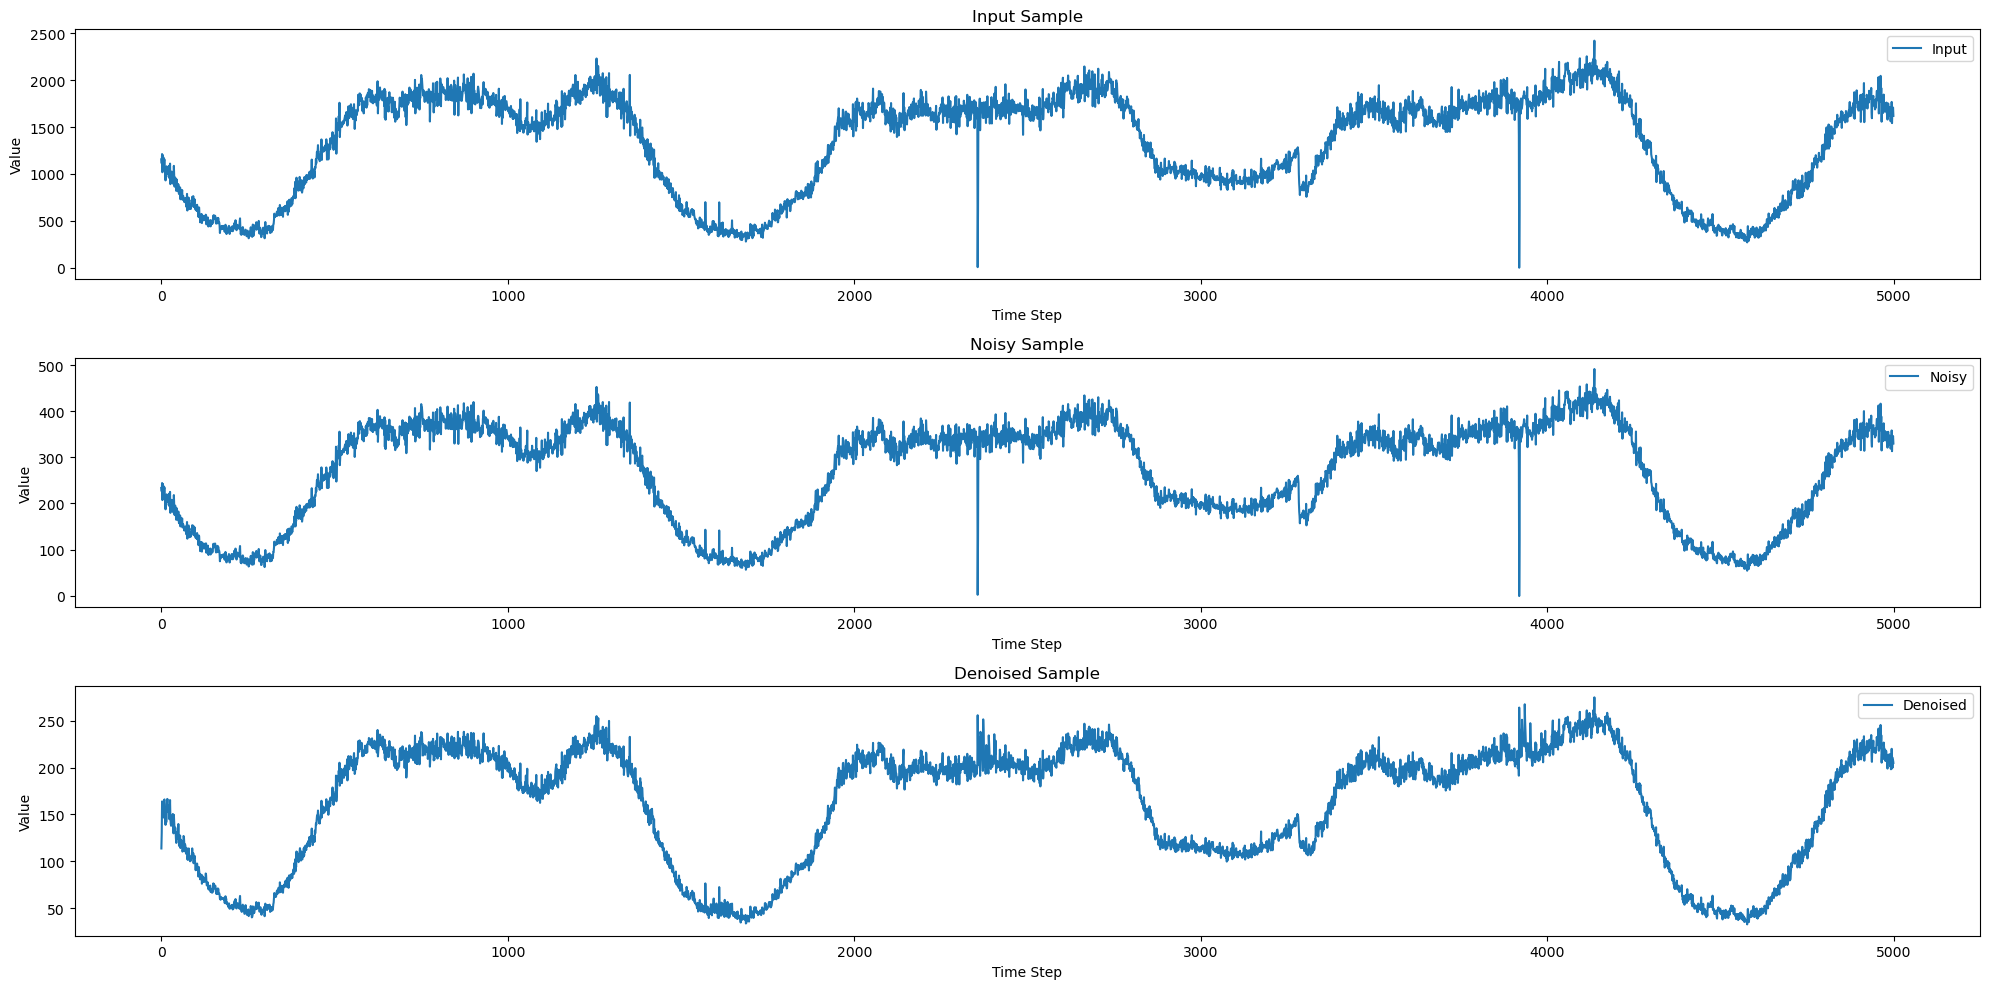

Epoch 49: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it, loss=1.88e+5, step=49]


In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

# Continue with the rest of your training loop...

sequence_length = 5000
input_size = 1  # Assuming 1D time series data


# Assuming you have the rest of your code defined already...

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        '''if model.input_shape == 'NCL':
            batch = batch.unsqueeze(1)  # Add channel dimension: (batch_size, 1, sequence_length)'''
        #elif model.input_shape == 'NLC':
            #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        #noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        #timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
        #timesteps = torch.linspace(0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]).long()
        std_data = torch.std(batch)

        # I want the noise level increasing with epoch
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) * std_data * noise_level
                
        #noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        #print("timesteps", timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        # pred noise from the model
        noise_pred = model(noisy)
        
        print("noise_pred", noise_pred.shape)
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)
                noise_level = 0.1
                noise = torch.randn_like(sample) #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()


  0%|          | 0/1 [00:00<?, ?it/s]

eval timesteps tensor([397, 257, 412, 464,  22, 344, 263,  93,  75, 250, 382, 247, 391, 405,
        164, 276])


Outliers: [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [ True]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [ True]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [ True]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
labels tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


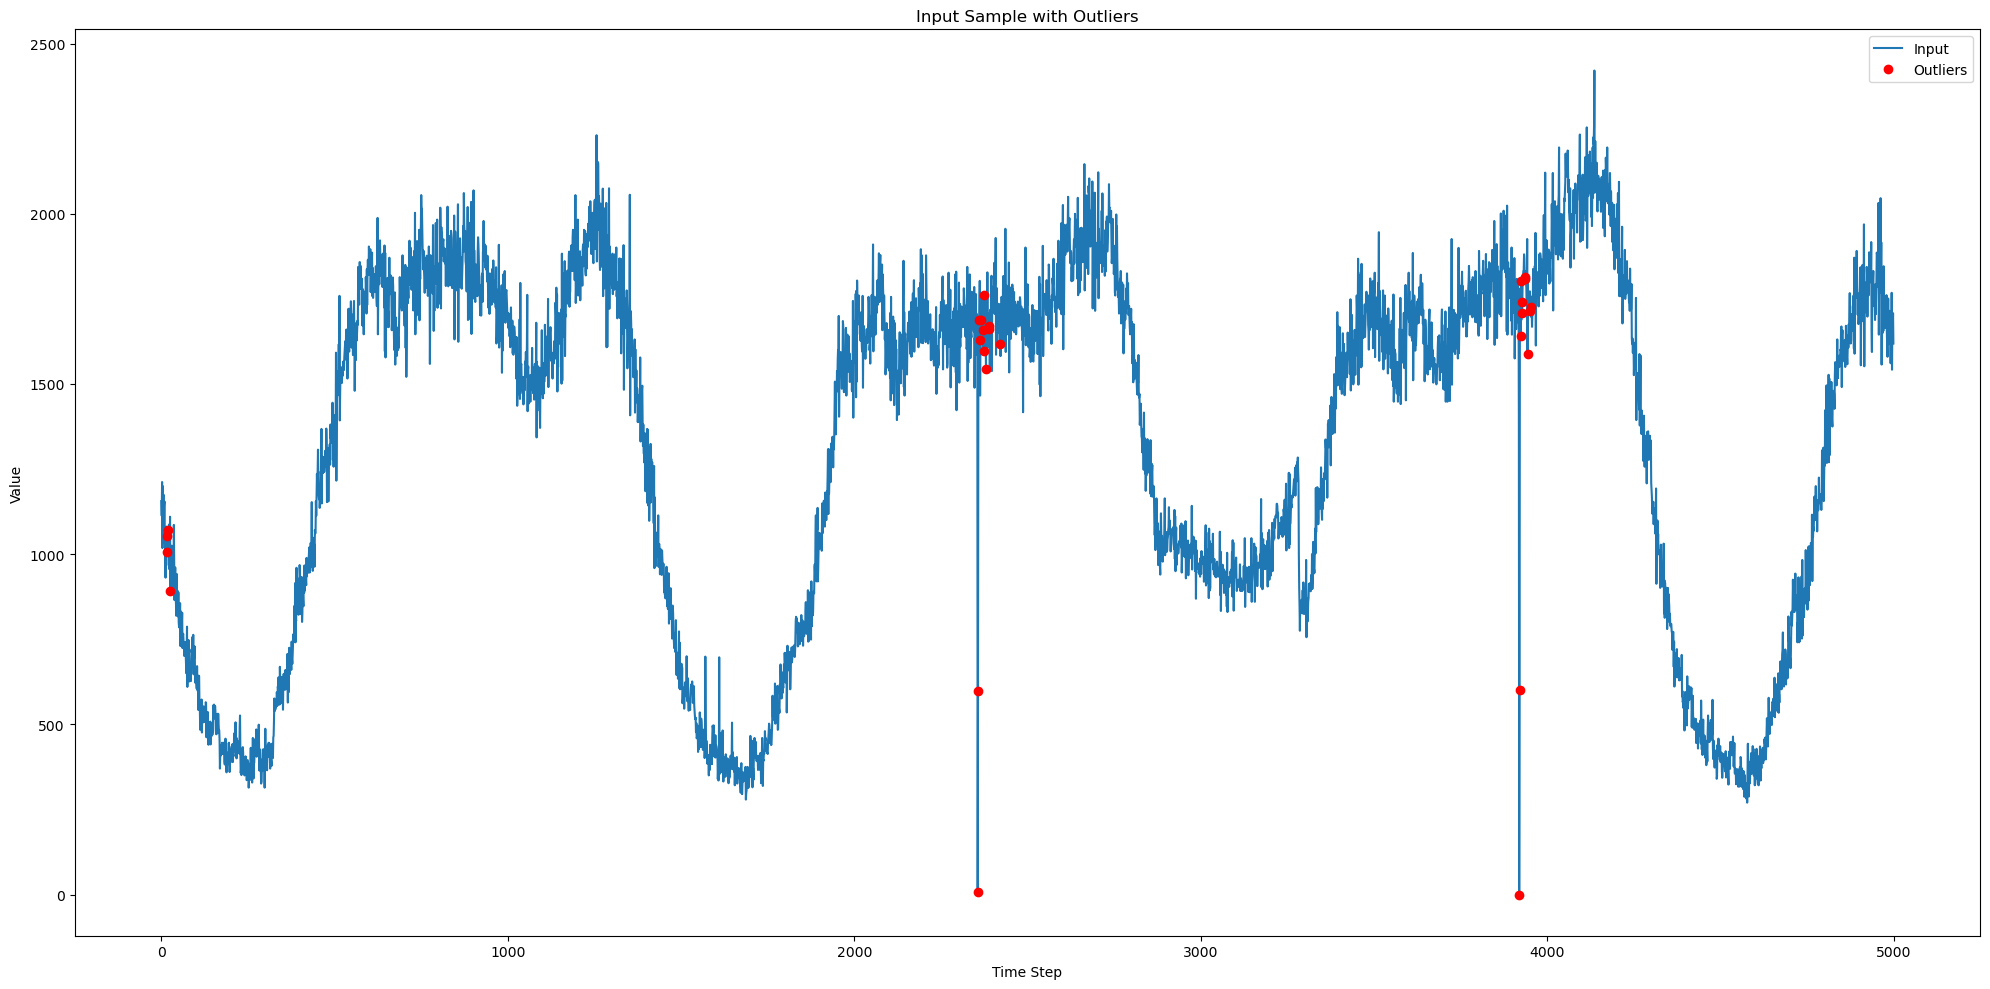

  0%|          | 0/1 [00:01<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4966
         1.0       0.33      0.26      0.30        34

    accuracy                           0.99      5000
   macro avg       0.66      0.63      0.65      5000
weighted avg       0.99      0.99      0.99      5000



In [22]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        std_data = torch.std(sample)
        noise_level = 0.5
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(sample) *2
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = std_data

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        # before the sample shape was (16, 5000) now it is (16,5000, 1)
        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")

        
        
    break
